## Аналитический тест

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm

import scipy.stats as ss
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Предподготовка данных
Рассмотрим исходный датасет и скорректируем его для удобства

In [2]:
df = pd.read_excel('Test (1).xlsx', usecols='B:Q')
df

,Год рождения,Адрес регистрации (регион),Адрес фактического проживания (регион),Работодатель есть/нет,Пол,Семейное положение,Образование,Тип клиента,Жилищные условия,Доход1,Доход2,Доход3,Доход4,Количество предоставленных телефонов,Количество предоставленных документов,Просроченная задолженность
0,1958,27,27,0,М,Холост/Не замужем,Среднее специальное,Пенсионер,Собственность индивидуальная,0.0,NaN,14200.0,10000.0,4,1,0
1,1947,47,47,1,М,Разведен/Разведена,Среднее специальное,Служащий,Собственность совместная,11000.0,NaN,0.0,0.0,5,1,0
2,1947,47,47,1,М,Разведен/Разведена,Среднее специальное,Служащий,Собственность совместная,11000.0,NaN,0.0,0.0,5,1,0
3,1990,55,55,1,Ж,Женат/Замужем,Среднее специальное,Служащий,Живу с родителями/родственниками,30000.0,NaN,0.0,0.0,6,1,0
4,1952,14,14,0,М,Вдовец/Вдова,Высшее,Пенсионер,Собственность индивидуальная,0.0,NaN,30000.0,20000.0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354439,1983,28,28,1,Ж,Холост/Не замужем,Среднее специальное,Служащий,Собственность совместная,45000.0,NaN,0.0,0.0,5,1,0
354440,1933,4,4,0,Ж,Женат/Замужем,Среднее,Пенсионер,Собственность индивидуальная,0.0,NaN,19000.0,0.0,2,1,0
354441,1981,38,38,1,М,Женат/Замужем,Незаконченное высшее,Служащий,Собственность индивидуальная,35000.0,NaN,0.0,0.0,5,1,0
354442,1939,64,64,0,Ж,Вдовец/Вдова,Среднее специальное,Пенсионер,Собственность индивидуальная,0.0,NaN,13200.0,2800.0,5,1,0


Переименуем столбцы для удобства

In [3]:
df = df.rename(columns={
    'Год рождения': 'birth_year',
    'Адрес регистрации (регион)': 'registration_address',
    'Адрес фактического проживания (регион)': 'actual_address',
    'Работодатель есть/нет': 'employer',
    'Пол': 'sex',
    'Семейное положение': 'family',
    'Образование': 'education',
    'Тип клиента': 'client_type',
    'Жилищные условия': 'living_conditions',
    'Доход1': 'revenue1',
    'Доход2': 'revenue2',
    'Доход3': 'revenue3',
    'Доход4': 'revenue4',
    'Количество предоставленных телефонов': 'phones_provided',
    'Количество предоставленных документов': 'documents_provided',
    'Просроченная задолженность': 'arrears'
})

Рассмотрим датасет и опишем данные

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354444 entries, 0 to 354443
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   birth_year            354444 non-null  int64  
 1   registration_address  354444 non-null  object 
 2   actual_address        354444 non-null  object 
 3   employer              354444 non-null  int64  
 4   sex                   354444 non-null  object 
 5   family                354444 non-null  object 
 6   education             354444 non-null  object 
 7   client_type           354444 non-null  object 
 8   living_conditions     354444 non-null  object 
 9   revenue1              354444 non-null  float64
 10  revenue2              10486 non-null   float64
 11  revenue3              354444 non-null  float64
 12  revenue4              354444 non-null  float64
 13  phones_provided       354444 non-null  int64  
 14  documents_provided    354444 non-null  int64  
 15  

Итак, мы имеем 16 столбцов с информацией о клиентах.
- __birth_year__ - Год рождения (имеет смысл перевести столбец в возраст);
- __registration_address__ - Адрес регистрации (регион);
- __actual_address__ - Адрес фактического проживания (регион);
- __employer__ - Наличие работодателя (0 и 1);
- __sex__ - Пол (М и Ж);
- __family__ - Семейное положение ('Вдовец/Вдова', 'Женат/Замужем', 'Неизвестно', 'Неофицальный брак', 'Разведен/Разведена', 'Холост/Не замужем');
- __education__ - Образование ('Среднее специальное', 'Высшее', 'Среднее', 'Неполное среднее', 'Незаконченное высшее', 'Неопределено', 'Другое', 'Несколько высших');
- __client_type__ - Тип клиента ('Пенсионер', 'Служащий', 'Владелец бизнеса', 'Неопределено', 'Работодатель', 'Студент');
- __living_conditions__ - Жилищные условия ('Собственность индивидуальная', 'Собственность совместная', 'Живу с родителями/родственниками', 'Аренда', 'Неопределено')
- __revenue(1,2,3,4)__ - 4 типа дохода (лучше объединить в один столбец);
- __phones_provided__ - Количество предоставленных телефонов;
- __documents_provided__ - Количество предоставленных документов;
- __arrears__ - Просроченная задолженность (0 и 1).

In [5]:
df.family.unique()

array(['Холост/Не замужем', 'Разведен/Разведена', 'Женат/Замужем',
       'Вдовец/Вдова', 'Неофицальный брак', 'Неизвестно '], dtype=object)

In [6]:
df.education.unique()

array(['Среднее специальное', 'Высшее', 'Среднее', 'Неполное среднее',
       'Незаконченное высшее', 'Неопределено', 'Другое',
       'Несколько высших'], dtype=object)

In [7]:
df.client_type.unique()

array(['Пенсионер', 'Служащий', 'Владелец бизнеса', 'Неопределено',
       'Работодатель', 'Студент'], dtype=object)

In [8]:
df.living_conditions.unique()

array(['Собственность индивидуальная', 'Собственность совместная',
       'Живу с родителями/родственниками', 'Аренда', 'Неопределено'],
      dtype=object)

`Revenue2` содержит много пропущенных значений, заполним их нулями, так как это доход.
Затем объединим четыре столбца с доходом в один.

In [9]:
df['revenue2'] = df.revenue2.fillna(value=0)

In [10]:
df['revenue_sum'] = df.revenue1 + df.revenue2 + df.revenue3 + df.revenue4

Посчитаем возраст клиентов и сохраним в отдельный столбец

In [11]:
df['age'] = 2022 - df.birth_year

Рассмотрим категориальные столбцы с местом жительства - по регистрации и фактическим

In [12]:
df.actual_address.unique()

array([27, 47, 55, 14, 38, 23, 44, 42, 77, 4, 54, 34, 56, 3, 24, 25, 76,
       74, 28, 72, 33, 2, 35, 78, 50, 52, 53, 61, 79, 36, 26, 64, 37, 66,
       19, 58, 16, 63, 59, 68, 48, 80, 41, 43, 71, 1, 30, 86, 13, 51, 11,
       45, 18, 46, 69, 73, 31, 40, 21, 57, 49, 29, 62, 10, ' СПБ', 12,
       ' РФ', 67, 9, 32, 'РЕСПУБЛИКА АБХАЗИЯ', 75, 'обл Костромкая', 60,
       83, 7, 8, 'обл. Ростогвская', 39, 'Респ Крым',
       'край Красноярс кий', 'Респ. Крым', 'край Краноярский',
       'обл Горьковская', 15, 20, 5, 'область Саратовкая', 'респ Крым',
       'обл Кемероская', 'край Красноряский', ' Крым', 82, ' Байконур',
       ' КЧР', ' Крым респ.', ' Россия', 'ОБЛАСТЬ ЧЕЛБЯИНСКАЯ', 84,
       'г Байконур', 87, ' Ханты-Манскийский', ' красногорск',
       'обл Нижего', 17, 'КРАЙ ПРИМОСКИЙ', 'область Лмпецкая', 'обл ТюМ',
       'край Краснярский', 'область Волгогардская',
       'ОБЛАСТЬ АСТРАХАНЬСКАЯ', 'обл Астрахань', ' РОССИЯ', ' НЕТ',
       'обл НовосИ'], dtype=object)

В данных много ошибок, заменим их на регионы городов

In [13]:
reg_adr = df.registration_address.replace(to_replace=r'^.*(?i)Крым.*$', value='82', regex=True) \
        .replace({' РФ': 0, 'обл Костромкая': 44, ' -': 0, 'обл. Ростогвская': 61, 'край Красноярс кий': 24, 
         'область Владимисркая': 33, 'край Забойкальский': 75, ' ЕВРЕЙКАЯ АВТОНОМНАЯ ОБЛАСТЬ': 79,
         'край Краноярский': 24, 'обл Горьковская': 52, 'область Саратовкая': 64, ' Краснодарсркий край': 23,
         ' СПБ': 78, 'край Красноряский': 24, ' МАРИЙСКАЯ АССР': 12, '82': 82, 'г Севастополь': 82, ' Россия': 0,
         'ОБЛАСТЬ ЧЕЛБЯИНСКАЯ': 74, 'г Байконур': 99, ' Ханты-Манскийский': 86, ' иваноская обл': 37,
         'обл Нижего': 52, 'ОБЛАСТЬ ТЮМЕНЬСКАЯ': 72, 'область Лмпецкая': 48, 'обл ТюМ': 72, 'край Краснярский': 24,
         'область Волгогардская': 34, 'обл Астрахн': 30, 'АССР МОРДОВСКАЯ': 13, ' РОССИЯ': 0, ' НЕТ': 0, 'обл НовосИ': 54})

df.registration_address = reg_adr

In [14]:
act_adr = df.actual_address.replace(to_replace=r'^.*(?i)Крым.*$', value='82', regex=True) \
        .replace({' РФ': 0, 'обл Костромкая': 44, ' -': 0, 'обл. Ростогвская': 61, 'край Красноярс кий': 24, 
         'область Владимисркая': 33, 'край Забойкальский': 75, ' ЕВРЕЙКАЯ АВТОНОМНАЯ ОБЛАСТЬ': 79,
         'край Краноярский': 24, 'обл Горьковская': 52, 'область Саратовкая': 64, ' Краснодарсркий край': 23,
         ' СПБ': 78, 'край Красноряский': 24, ' МАРИЙСКАЯ АССР': 12, '82': 82, 'г Севастополь': 82, ' Россия': 0,
         'ОБЛАСТЬ ЧЕЛБЯИНСКАЯ': 74, 'г Байконур': 99, ' Ханты-Манскийский': 86, ' иваноская обл': 37,
         'обл Нижего': 52, 'ОБЛАСТЬ ТЮМЕНЬСКАЯ': 72, 'область Лмпецкая': 48, 'обл ТюМ': 72, 'край Краснярский': 24,
         'область Волгогардская': 34, 'обл Астрахн': 30, 'АССР МОРДОВСКАЯ': 13, ' РОССИЯ': 0, ' НЕТ': 0, 'обл НовосИ': 54,
         'РЕСПУБЛИКА АБХАЗИЯ': 'abh', 'обл Кемероская': 42, ' Байконур': 99, ' КЧР': 9, ' красногорск': 50, 
         'КРАЙ ПРИМОСКИЙ': 25, 'ОБЛАСТЬ АСТРАХАНЬСКАЯ': 30, 'обл Астрахань': 30})

df.actual_address = act_adr

In [15]:
df.nunique()

birth_year                 68
registration_address       84
actual_address             84
employer                    2
sex                         2
family                      6
education                   8
client_type                 6
living_conditions           5
revenue1                 3944
revenue2                  295
revenue3                 5499
revenue4                 1225
phones_provided             7
documents_provided          6
arrears                     2
revenue_sum             10174
age                        68
dtype: int64

Категорий очень много и сравнивать их между собой будет нерационально. Объединим их по федеральным округам. Будем использовать только столбец с фактическим проживанием.

In [16]:
df['federal_district'] = df.actual_address.copy()
df.federal_district.loc[df.federal_district.isin([0, 31, 32, 33, 36, 37, 40, 44, 
                                                  46, 48, 50, 57, 62, 67, 68, 69, 71, 76, 77])] = 'central'
df.federal_district.loc[df.federal_district.isin(['abh', 1, 30, 34, 8, 61, 82, 23, 80, 99, 84])] = 'south'
df.federal_district.loc[df.federal_district.isin([29, 35, 39, 10, 11, 47, 51, 83, 53, 60, 78])] = 'northwest'
df.federal_district.loc[df.federal_district.isin([28, 3, 79, 75, 41, 49, 25, 14, 65, 27, 87])] = 'fareast'
df.federal_district.loc[df.federal_district.isin([4, 22, 38, 42, 24, 54, 55, 70, 17, 19])] = 'siberian'
df.federal_district.loc[df.federal_district.isin([45, 66, 72, 86, 74])] = 'ural'
df.federal_district.loc[df.federal_district.isin([2, 43, 12, 13, 52, 56, 58, 59, 63, 64, 16, 18, 73, 21])] = 'volga'
df.federal_district.loc[df.federal_district.isin([5, 6, 7, 9, 15, 26, 20])] = 'caucasian'

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
df.federal_district.unique()

array(['fareast', 'northwest', 'siberian', 'south', 'central', 'volga',
       'ural', 'caucasian'], dtype=object)

Теперь исключим из датасета ненужные столбцы.

In [18]:
df = df.drop(['birth_year', 'revenue1', 'revenue2', 'revenue3', 'revenue4', 'registration_address', 'actual_address'], axis=1)

In [19]:
pd.crosstab(df.arrears, df.family)

family,Вдовец/Вдова,Женат/Замужем,Неизвестно,Неофицальный брак,Разведен/Разведена,Холост/Не замужем
arrears,,,,,,
0,49860,139890,51149,23583,41541,45289
1,466,1204,0,308,527,627


In [20]:
pd.crosstab(df.arrears, df.education)

education,Высшее,Другое,Незаконченное высшее,Неопределено,Неполное среднее,Несколько высших,Среднее,Среднее специальное
arrears,,,,,,,,
0,56923,566,7238,53873,11453,364,86815,134080
1,431,0,89,0,122,1,1002,1487


In [21]:
pd.crosstab(df.arrears, df.client_type)

client_type,Владелец бизнеса,Неопределено,Пенсионер,Работодатель,Служащий,Студент
arrears,,,,,,
0,4591,36913,123226,621,185775,186
1,42,0,932,5,2148,5


In [22]:
pd.crosstab(df.arrears, df.living_conditions)

living_conditions,Аренда,Живу с родителями/родственниками,Неопределено,Собственность индивидуальная,Собственность совместная
arrears,,,,,
0,23336,8044,53818,230300,35814
1,283,105,0,2269,475


В почти всех категориальных переменных есть клиенты с отсутствующей информацией, причем все они не являются должниками. Уберем строки с информацией об этих клиентах, так как они могут исказить картину и конечную математическую модель.

In [23]:
df = df.query("family != 'Неизвестно' and education != 'Неопределено' \
              and client_type != 'Неопределено' and living_conditions != 'Неопределено'")

In [103]:
df.duplicated().value_counts()

False    172351
True     128220
dtype: int64

Также в данных достаточно много дубликатов - мы не будем их убирать из датасета, такое вполне могло произойти из-за объединения нескольких столбцов. Кроме того, так может исказиться картина, описываемая данными.

In [24]:
df.head()

,employer,sex,family,education,client_type,living_conditions,phones_provided,documents_provided,arrears,revenue_sum,age,federal_district
0,0,М,Холост/Не замужем,Среднее специальное,Пенсионер,Собственность индивидуальная,4,1,0,24200.0,64,fareast
1,1,М,Разведен/Разведена,Среднее специальное,Служащий,Собственность совместная,5,1,0,11000.0,75,northwest
2,1,М,Разведен/Разведена,Среднее специальное,Служащий,Собственность совместная,5,1,0,11000.0,75,northwest
3,1,Ж,Женат/Замужем,Среднее специальное,Служащий,Живу с родителями/родственниками,6,1,0,30000.0,32,siberian
4,0,М,Вдовец/Вдова,Высшее,Пенсионер,Собственность индивидуальная,5,1,0,50000.0,70,fareast


### Разведочный анализ данных

Теперь изучим наши данные, посмотрим какие есть зависимости между переменными и насколько эти зависимости статистически значимы.

#### Описание данных

In [25]:
df.describe()

,employer,phones_provided,documents_provided,arrears,revenue_sum,age
count,300571.000000,300571.000000,300571.000000,300571.000000,3.005710e+05,300571.000000
mean,0.643262,4.905706,0.952261,0.010420,2.801959e+04,56.116172
std,0.479037,1.159768,0.307723,0.101546,3.262845e+04,14.676393
min,0.000000,1.000000,0.000000,0.000000,1.000000e+00,24.000000
25%,0.000000,4.000000,1.000000,0.000000,1.500000e+04,44.000000
50%,1.000000,5.000000,1.000000,0.000000,2.200000e+04,58.000000
75%,1.000000,6.000000,1.000000,0.000000,3.300000e+04,68.000000
max,1.000000,7.000000,5.000000,1.000000,3.500000e+06,91.000000


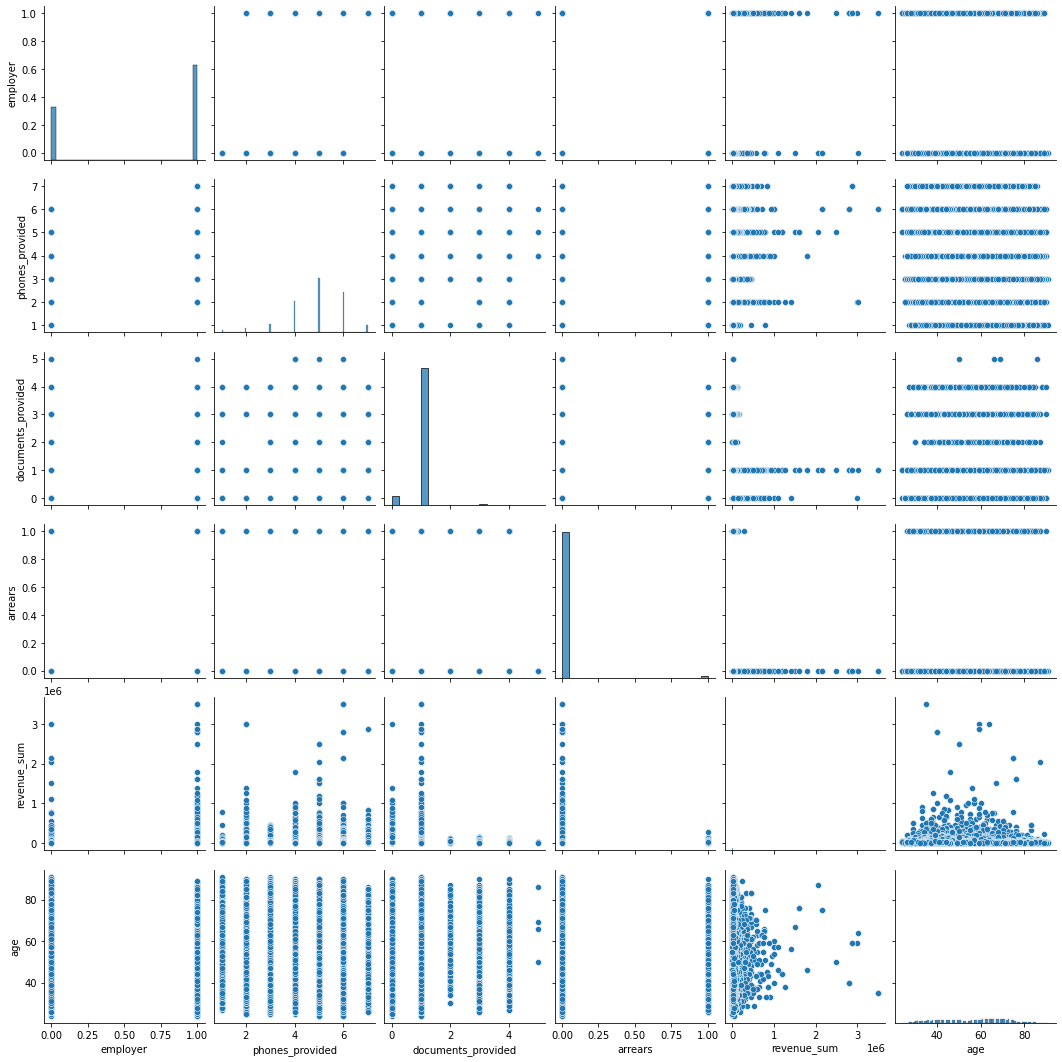

In [26]:
sns.pairplot(df)

#### Прогнозируемая переменная (желаемая цель):

`arrears` — просрочил ли клиент платеж (двоично: “1” означает “Да”, “0” означает “Нет”).

In [27]:
df.arrears.value_counts()

0    297439
1      3132
Name: arrears, dtype: int64

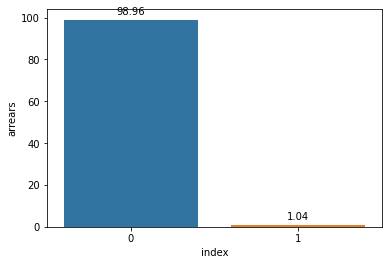

In [28]:
ax = sns.barplot(data=df.arrears.value_counts(normalize=True).mul(100).reset_index(), y='arrears', x='index')
for bar in ax.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

Данные значительно скошены в одну сторону, клиентов с просроченной задолженностью около 1% в данных.  
Прежде чем мы перейдём к балансировке, давайте проведём дополнительное исследование переменных и взаимосвязей между ними.

### Исследование взаимосвязей между переменными
Исследуем взаимосвязи между разными переменными и переменной `Arrears` - Просрочил оплату долга или нет.

#### Arrears - Sex
Посмотрим на взаимосвязь пола клиента и есть у него просроченная задолженность или нет

Text(0.5, 0.98, 'Arrears vs Sex')

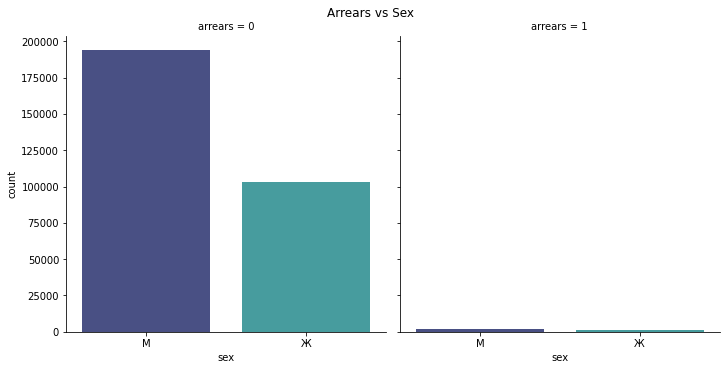

In [29]:
g = sns.catplot(data = df, x = 'sex', col = 'arrears', kind = 'count', palette='mako')

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Arrears vs Sex')

Два распределения частот сравнивать неудобно, так как должников очень мало в датасете. Переведем данные в процентные значения.

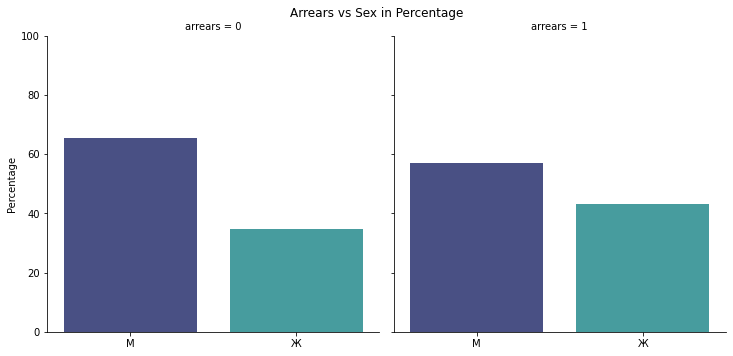

In [30]:
df_sex = df.groupby('arrears')['sex'].value_counts(normalize=True).mul(100).round(2).to_frame('perc').reset_index()
g = sns.catplot(data = df_sex, x = 'sex', y='perc', col = 'arrears', kind = 'bar', palette='mako')

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Arrears vs Sex in Percentage')
g.set_axis_labels("", "Percentage")
g.set(ylim=(0, 100))

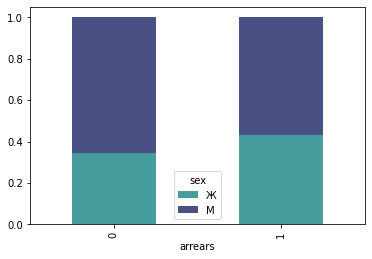

In [31]:
table = pd.crosstab(df.arrears, df.sex)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['#479c9e', '#495084'])

In [32]:
df.groupby('arrears')['sex'].value_counts(normalize=True)

arrears  sex
0        М      0.652813
         Ж      0.347187
1        М      0.568646
         Ж      0.431354
Name: sex, dtype: float64

Делать выводы только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → воспользуемся критерием хи-квадрат Пирсона:

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [33]:
pd.crosstab(df.sex, df.arrears, margins=True)

arrears,0,1,All
sex,,,
Ж,103267,1351,104618
М,194172,1781,195953
All,297439,3132,300571


In [34]:
ss.chi2_contingency(pd.crosstab(df.sex, df.arrears))

(96.38771405263448,
 9.445145180613242e-23,
 1,
 array([[103527.86297414,   1090.13702586],
        [193911.13702586,   2041.86297414]]))

`P-value = 9.44 * 10^(-23) < 0.05` - есть основания отклонить $H_0$. Это значит, что взаимосвязь между переменными *Пол* и *Должник* - `ЕСТЬ`.  
Среди должников женщин и мужчин почти поровну, а среди тех, кто платит вовремя больше мужчин, чем женщин.

#### Arrears - Employer
Взаимосвязь между наличием работодателя и наличием просроченной задолженности.

In [35]:
df.groupby('arrears')['employer'].value_counts(normalize=True)

arrears  employer
0        1           0.642639
         0           0.357361
1        1           0.702427
         0           0.297573
Name: employer, dtype: float64

Построим распределение сразу в процентах

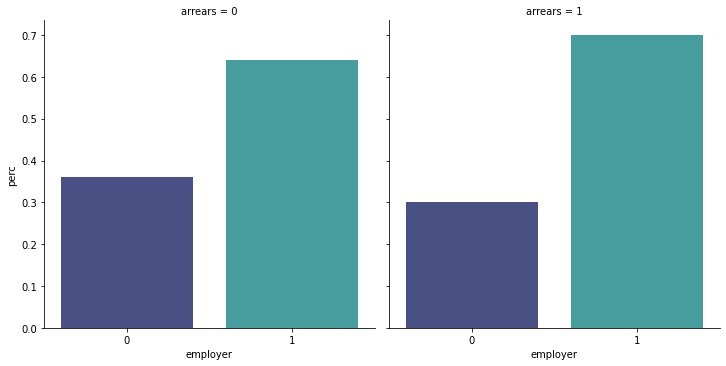

In [36]:
df_employer = df.groupby(['arrears'])['employer'].value_counts(normalize=True).round(2).to_frame('perc').reset_index()
sns.catplot(x = 'employer', y='perc', col = 'arrears', kind = 'bar', data = df_employer, palette='mako')

Также воспользуемся критерием хи-квадрат Пирсона для сравнения двух категориальных переменных.

In [37]:
pd.crosstab(df.employer, df.arrears, margins=True)

arrears,0,1,All
employer,,,
0,106293,932,107225
1,191146,2200,193346
All,297439,3132,300571


In [38]:
ss.chi2_contingency(pd.crosstab(df.employer, df.arrears))

(48.018162346168666,
 4.222892520276323e-12,
 1,
 array([[106107.6975989,   1117.3024011],
        [191331.3024011,   2014.6975989]]))

Для групп `Задолженность - Наличие работодателя` также найдена статистически значимая взаимосвязь.
Судя по всему, должники скорее устроены на работу, чем нет.

__Arrears - Revenue__  
Взаимосвязь между доходом клиента и наличием просроченной задолженности.

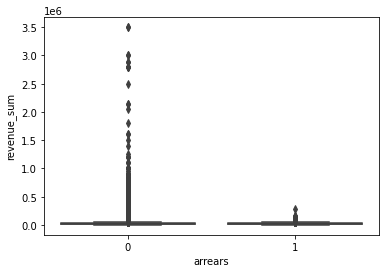

In [39]:
sns.boxplot(data=df, x='arrears', y='revenue_sum')

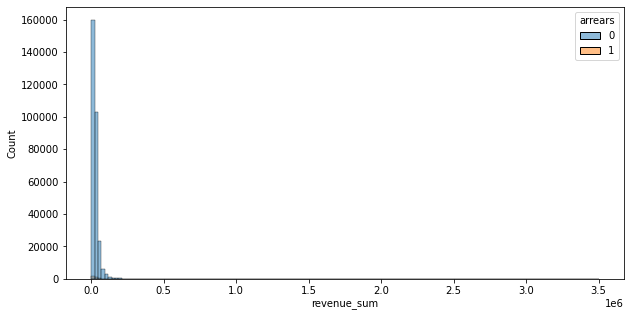

In [40]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='revenue_sum', hue='arrears', bins=150)

Переменная "Доход" клиентов распределена ненормально с отклонением влево. Применять т-тест на таких данных нецелесообразно, результаты будут некорректны. Можем попробовать прологарифмировать данные и сравнить их.

In [41]:
df_revenue = df[['revenue_sum', 'arrears']]
df_revenue.revenue_sum = df_revenue.revenue_sum + 1
df_revenue['revenue_log'] = np.log(df_revenue.revenue_sum)

df_revenue.head()

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,revenue_sum,arrears,revenue_log
0,24201.0,0,10.094149
1,11001.0,0,9.305741
2,11001.0,0,9.305741
3,30001.0,0,10.308986
4,50001.0,0,10.819798


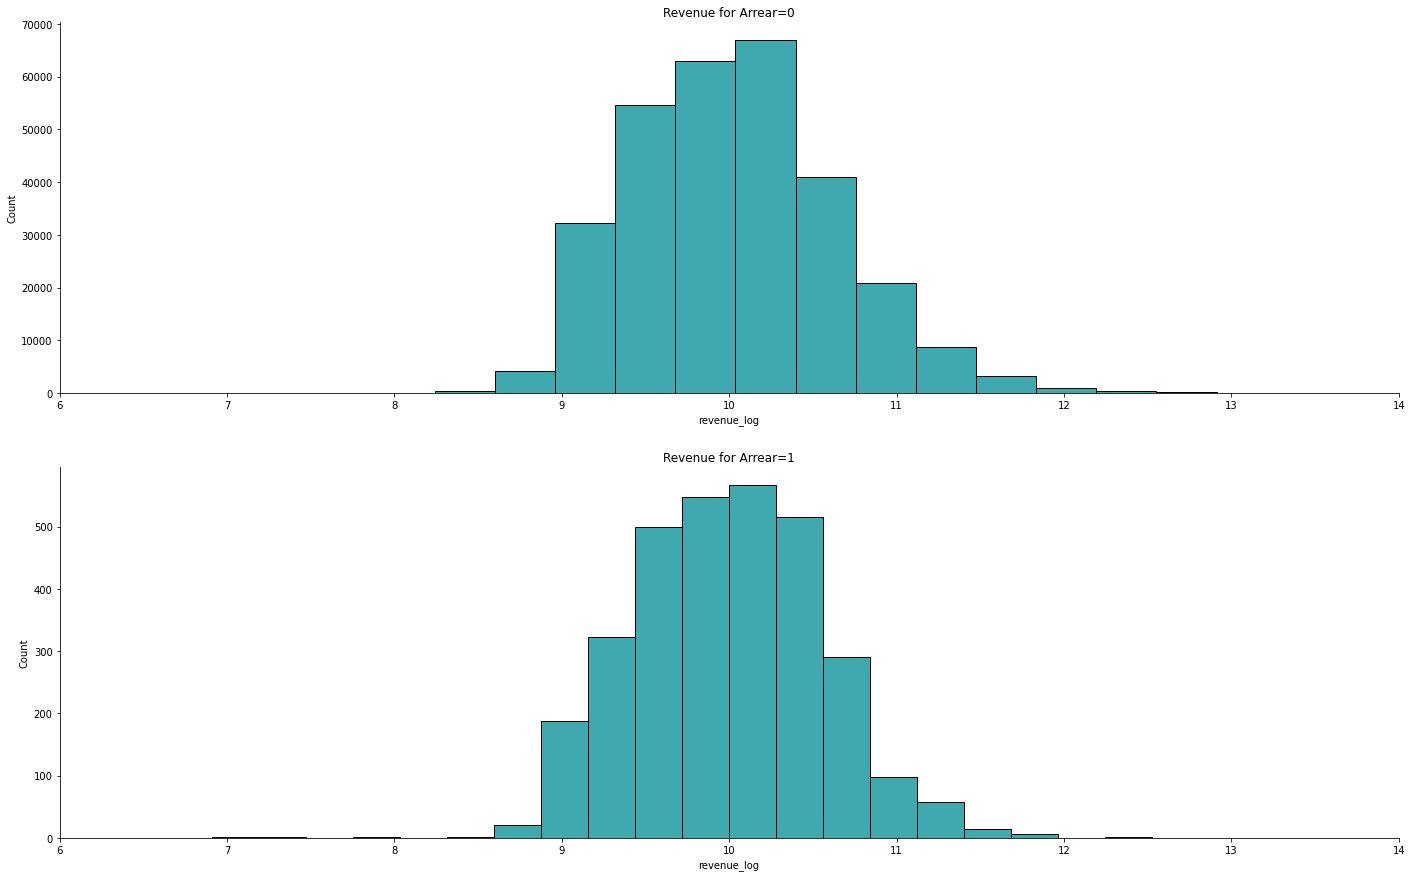

In [42]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 15))

sns.histplot(data=df_revenue.loc[df_revenue.arrears == 0], x='revenue_log', bins=40, ax=ax1, color='#008c95')
ax1.set(xlim=(6, 14))
ax1.set_title('Revenue for Arrear=0')

sns.histplot(data=df_revenue.loc[df_revenue.arrears == 1], x='revenue_log', bins=20, ax=ax2, color='#008c95')
ax2.set(xlim=(6, 14))
ax2.set_title('Revenue for Arrear=1')

sns.despine()

Как видно из графика, данные распределения уже больше похожи на нормальное, но все же есть небольшие выбросы. Т-критерий Стьюдента можно было бы применить в случае более менее равных дисперсий, но результаты будет сложно интерпретировать. Рассмотрим другие варианты.

#### U-тест Mann-Whitney
Теперь применим `непараметрический критерий Манна-Уитни` для сравнения двух распределений.  
`H0` - Различий в двух выборках нет;  
`H1` - Различия есть, и они статистически значимы.

Тоже неплохой вариант, но так как размеры выборок `arrears = 0` и `arrears = 1` сильно отличаются, критерий Манна-Уитни лучше не применять.

Сравнивать результаты статистических тестов некорректно, но ради интереса посчитаем U-тест и Т-тест.

In [43]:
# Сравним дисперсии выборок 0 и 1 по переменной Arrears
print('Дисперсия распределения клиентов без просрока задолженности:', df_revenue.loc[df_revenue.arrears == 0].revenue_log.var())
print('Дисперсия распределения клиентов с просроком задолженности:', df_revenue.loc[df_revenue.arrears == 1].revenue_log.var())

Дисперсия распределения клиентов без просрока задолженности: 0.3803744055109599
Дисперсия распределения клиентов с просроком задолженности: 0.3118303830264177


In [44]:
# Тест Левене о проверке разности дисперсий распределений
ss.levene(df_revenue.loc[df_revenue.arrears == 0].revenue_log, df_revenue.loc[df_revenue.arrears == 1].revenue_log)

LeveneResult(statistic=32.55312169261237, pvalue=1.1608716762870343e-08)

В критерии Левене `p-value < 0.05`, это значит дисперсии логарифмических распределений значимо отличаются. Т-тест не очень подходит и в случае логарифма распределения.

In [45]:
print('Среднее распределения клиентов без просрока', df_revenue.loc[df_revenue.arrears == 0].revenue_log.mean())
print('Среднее распределения клиентов с просроком', df_revenue.loc[df_revenue.arrears == 1].revenue_log.mean())

Среднее распределения клиентов без просрока 10.024366862012789
Среднее распределения клиентов с просроком 9.98258254258213


Кажется, что средние почти не отличаются в выборках. Проверим это статистически.

In [46]:
# U-тест Манна-Уитни
ss.mannwhitneyu(df[df.arrears == 0].revenue_sum, df[df.arrears == 1].revenue_sum)

MannwhitneyuResult(statistic=476584017.0, pvalue=0.025381226587919116)

In [47]:
# Т-тест Стьюдента
ss.ttest_ind(df_revenue.loc[df_revenue.arrears == 0].revenue_log, df_revenue.loc[df_revenue.arrears == 1].revenue_log)

Ttest_indResult(statistic=3.7753044821006783, pvalue=0.0001598430442257182)

Оба теста показали стат. значимые различия в выборках, но как я сказал ранее, применение этих критериев в данном кейсе некорректно.

Мы рассмотрели разные стат. критерии, но ни один из них не подходит для наши данных.
Тем не менее есть метод, который достаточно универсален и его можно применять даже на таких ненормальных выборках, как у нас. Это `bootstrap`. В данном случае применим бутстрап средних.

**Bootstrap**

Как проверяются гипотезы с помощью бутстрапа?
1. Строим бутстрап-распределения параметра в А и Б;
2. Вычисляем их разницу (вычитание матриц);
3. В получившемся распределении разницы считаем доверительный интервал;
4. Смотрим, попадает ли доверительный интервал в 0. И если да, то нулевая гипотеза на заданном уровне значимости принимается.

In [48]:
# Bootstrap function
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

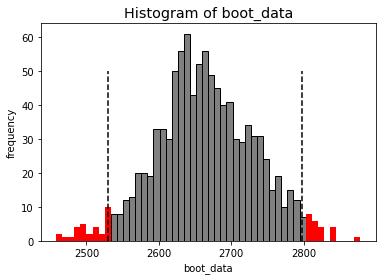

In [49]:
a = get_bootstrap(df[df.arrears == 0].revenue_sum, df[df.arrears == 1].revenue_sum, statistic = np.mean)

In [50]:
# доверительный интервал для бутстрап распределения
a['quants']

,0
0.025,2529.306074
0.975,2798.027165


In [51]:
# Значение p-value получившегося распределения
a['p_value']

0.0

In [52]:
# средний доход клиентов без/с просроченными задолженностями
df[df.arrears == 0].revenue_sum.mean(), df[df.arrears == 1].revenue_sum.mean()

(28047.3393136744, 25384.02157407407)

Итак, результаты бутстрапа средних показали, что доверительный интервал далек от 0 и `p-value < 0.05`. Это значит, что выборки статистически значимо отличаются друг от друга - клиенты с меньшим доходом вероятнее всего будут должниками, чем клиенты с высоким.

__Arrears - Age__  
Взаимосвязь между возрастом клиента и наличием просроченной задолженности.

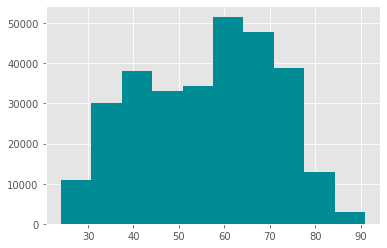

In [53]:
df.age.hist(color='#008c95')

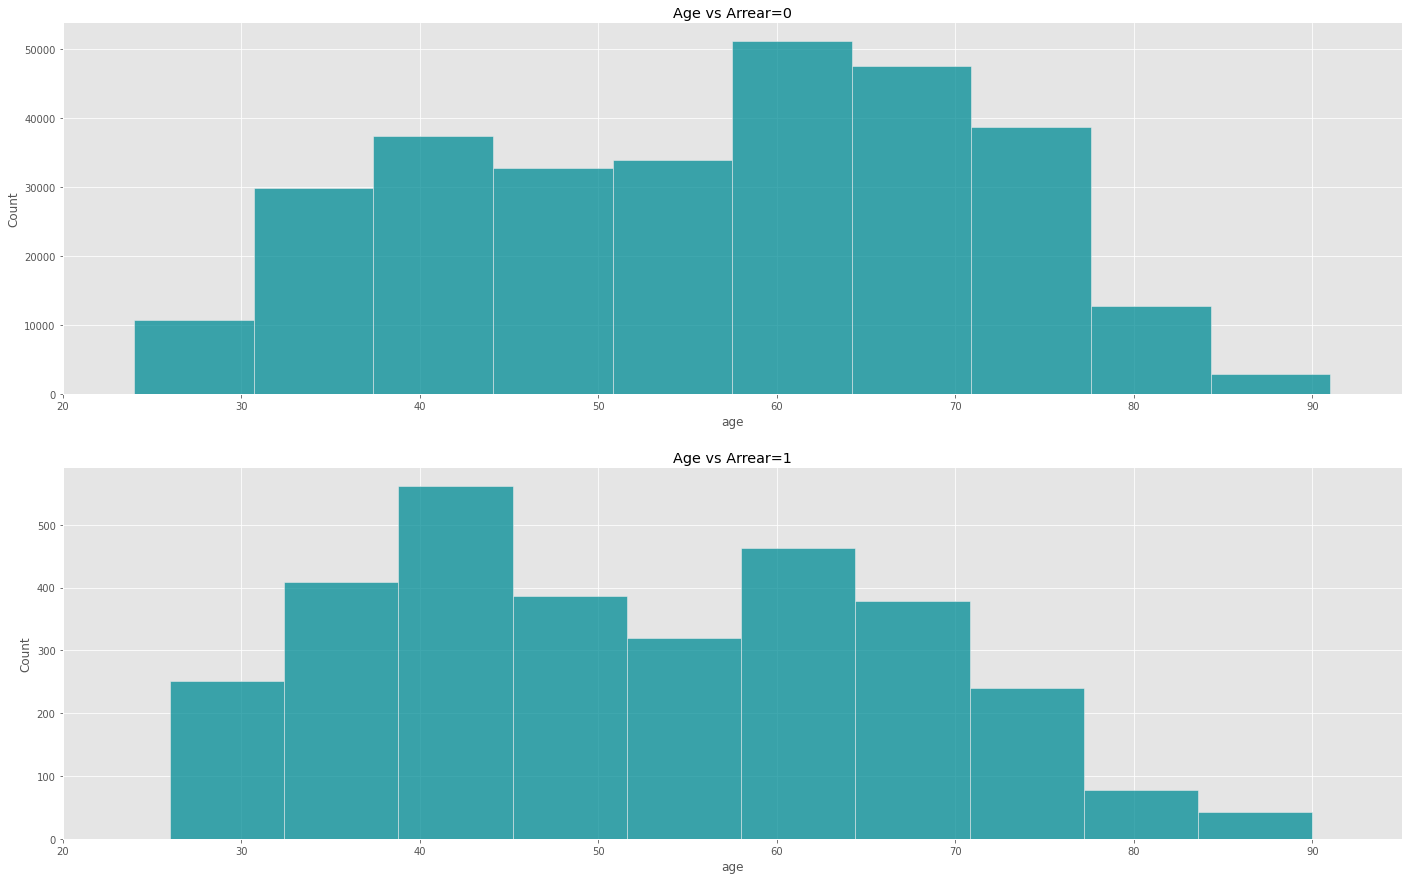

In [54]:
# Разделим две выборки на отдельные графики
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 15))

sns.histplot(data=df.loc[df.arrears == 0], x='age', bins=10, ax=ax1, color='#008c95')
ax1.set(xlim=(20, 95))
ax1.set_title('Age vs Arrear=0')

sns.histplot(data=df.loc[df.arrears == 1], x='age', bins=10, ax=ax2, color='#008c95')
ax2.set(xlim=(20, 95))
ax2.set_title('Age vs Arrear=1')

sns.despine()

Как видно из графика, возраст большинства клиентов распределен в интервале от 40 до 80 лет.

Снова вопрос, какой стат. тест использовать для сравнения распределений?  
Для начала проверим распределение возрастов клиентов на нормальность.

In [55]:
# тест Д'Агостино-Пирсона на нормальность
ss.normaltest(df.age)

NormaltestResult(statistic=60977.178605121844, pvalue=0.0)

Так, распределение ненормально. А дисперсия двух выборок с/без просрока?

In [56]:
df.loc[df.arrears == 0].age.var(), df.loc[df.arrears == 1].age.var()

(215.3067219388521, 207.7022397456653)

In [57]:
# Тест о равенстве дисперсий
ss.levene(df.loc[df.arrears == 0].age, df.loc[df.arrears == 1].age)

LeveneResult(statistic=1.8204211273760789, pvalue=0.1772641733391705)

А вот дисперсии стат. значимо не отличаются. В целом можно воспользоваться и т-тестом Стьюдента, так как выборки достаточно большие и нормальностью распределений можно принебречь. К тому же выбросов тоже не наблюдается.

In [58]:
# Т-тест Стьюдента
ss.ttest_ind(df.loc[df.arrears == 0].age, df.loc[df.arrears == 1].age)

Ttest_indResult(statistic=15.395122218382237, pvalue=1.8500074701992936e-53)

In [59]:
df.loc[df.arrears == 0].age.mean(), df.loc[df.arrears == 1].age.mean()

(56.1584459334519, 52.10153256704981)

Похоже, что распределения возрастов клиентов с просроченной задолженностью и без нее стат. значимо отличаются. Клиенты помоложе вероятнее могут просрочить платеж, чем клиенты постарше.

#### Матрица корреляции

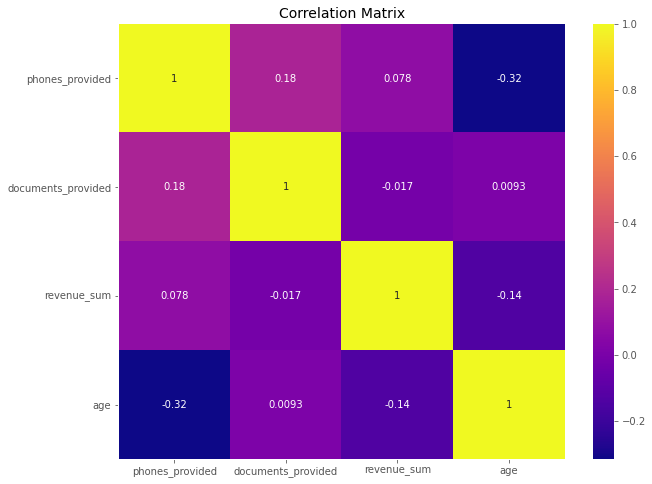

In [60]:
# Корреляция дискретных переменных
corr = df[['phones_provided', 'documents_provided', 'revenue_sum', 'age']].corr()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, cmap=plt.cm.plasma)
ax.set_title("Correlation Matrix", fontsize=14)
ax.set_yticklabels(corr.columns, rotation=0)

sns.despine()

Матрица корреляций между дискретными переменными показала, что наибольшая корреляция наблюдается между переменными __phones_provided__ и __age__. Причем эта связь отрицательная - чем больше возраст клиента, тем меньше он предоставляет телефонов. Проверим эту взаимосвязь на статистическую значимость.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


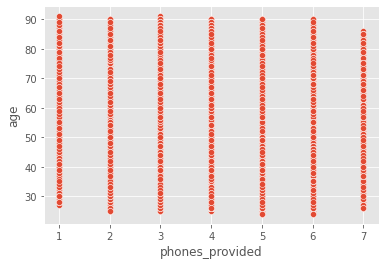

In [61]:
sns.scatterplot(df.phones_provided, df.age)

In [62]:
# Коэффициент корреляции Пирсона
r = ss.pearsonr(df.phones_provided, df.age)
print(f'Коэффициент корреляции Пирсона: {r[0]:.2f} \nP-value: {r[1]:.2f}')

Коэффициент корреляции Пирсона: -0.32 
P-value: 0.00


In [63]:
# Непараметрический коэффициент корреляции Спирмена
s = ss.spearmanr(df.phones_provided, df.age)
print(f'Коэффициент корреляции Спирмена: {s[0]:.2f} \nP-value: {s[1]:.2f}')

Коэффициент корреляции Спирмена: -0.35 
P-value: 0.00


Хотя результаты тестов показали p-value < 0.05, и взаимосвязь (корреляция) между числом предоставленных телефонов и возрастом клиентов статистически значима. Она не имеет никакого смысла, так как по факту переменная __phones_provided__ является категориальной, но с большим количеством категорий. Тоже самое с __documents_provided__.

#### Исследование взаимосвязи с мультиномиальными категориальными переменными
Рассмотрим взаимодействие `Arrears` с другими категориальными переменными, представленными в датасете.

Text(0, 0.5, 'Frequency of debt')

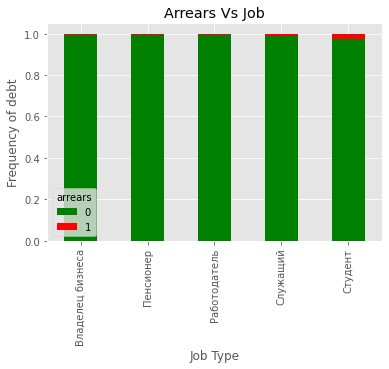

In [64]:
table = pd.crosstab(df.client_type, df.arrears)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Arrears Vs Job')
plt.xlabel('Job Type')
plt.ylabel('Frequency of debt')

In [65]:
df.groupby('client_type')['arrears'].value_counts(normalize=True)

client_type       arrears
Владелец бизнеса  0          0.990931
                  1          0.009069
Пенсионер         0          0.991308
                  1          0.008692
Работодатель      0          0.992013
                  1          0.007987
Служащий          0          0.988568
                  1          0.011432
Студент           0          0.973822
                  1          0.026178
Name: arrears, dtype: float64

Судя по всему, тип занятости не сильно влияет на наличие просроченной задолженности

Text(0, 0.5, 'Frequency of debt')

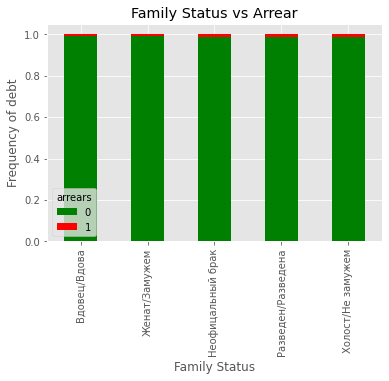

In [66]:
table = pd.crosstab(df.family, df.arrears)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Family Status vs Arrear')
plt.xlabel('Family Status')
plt.ylabel('Frequency of debt')

In [67]:
df.groupby('family')['arrears'].value_counts(normalize=True)

family              arrears
Вдовец/Вдова        0          0.990697
                    1          0.009303
Женат/Замужем       0          0.991387
                    1          0.008613
Неофицальный брак   0          0.987082
                    1          0.012918
Разведен/Разведена  0          0.987403
                    1          0.012597
Холост/Не замужем   0          0.986072
                    1          0.013928
Name: arrears, dtype: float64

Та же ситуация с семейным положением. Данная переменная не является существенным прогнозирующим фактором.

Text(0, 0.5, 'Frequency of debt')

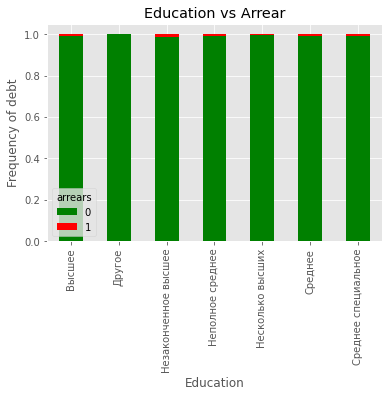

In [68]:
table = pd.crosstab(df.education, df.arrears)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Education vs Arrear')
plt.xlabel('Education')
plt.ylabel('Frequency of debt')

In [69]:
df.groupby('education')['arrears'].value_counts(normalize=True)

education             arrears
Высшее                0          0.992485
                      1          0.007515
Другое                0          1.000000
Незаконченное высшее  0          0.987853
                      1          0.012147
Неполное среднее      0          0.989460
                      1          0.010540
Несколько высших      0          0.997260
                      1          0.002740
Среднее               0          0.988590
                      1          0.011410
Среднее специальное   0          0.989031
                      1          0.010969
Name: arrears, dtype: float64

Возможно некоторые признаки типа образования могут статистически значимо влиять на зависимую переменную - `Arrears`.

Text(0, 0.5, 'Frequency of debt')

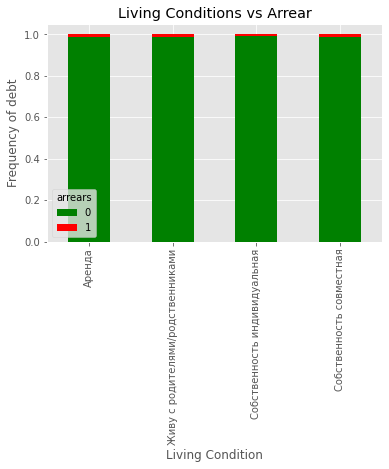

In [70]:
table = pd.crosstab(df.living_conditions, df.arrears)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Living Conditions vs Arrear')
plt.xlabel('Living Condition')
plt.ylabel('Frequency of debt')

In [71]:
df.groupby('living_conditions')['arrears'].value_counts(normalize=True)

living_conditions                 arrears
Аренда                            0          0.988017
                                  1          0.011983
Живу с родителями/родственниками  0          0.987115
                                  1          0.012885
Собственность индивидуальная      0          0.990242
                                  1          0.009758
Собственность совместная          0          0.986908
                                  1          0.013092
Name: arrears, dtype: float64

Тип жилья может не являться существенным прогнозирующим фактором.

Text(0, 0.5, 'Frequency of debt')

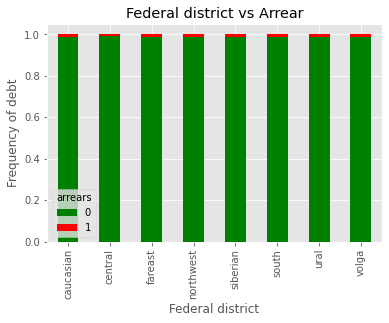

In [72]:
table = pd.crosstab(df.federal_district, df.arrears)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['g', 'r'])
plt.title('Federal district vs Arrear')
plt.xlabel('Federal district')
plt.ylabel('Frequency of debt')

In [73]:
df.groupby('federal_district')['arrears'].value_counts(normalize=True)

federal_district  arrears
caucasian         0          0.989210
                  1          0.010790
central           0          0.990959
                  1          0.009041
fareast           0          0.988952
                  1          0.011048
northwest         0          0.989618
                  1          0.010382
siberian          0          0.990074
                  1          0.009926
south             0          0.988690
                  1          0.011310
ural              0          0.988502
                  1          0.011498
volga             0          0.988589
                  1          0.011411
Name: arrears, dtype: float64

Местоположение клиента также может не являться существенным прогнозирующим фактором.

#### Arrears - Sex - Client_type
Взаимосвязь пола и типа занятости от наличия просроченной задолженности.

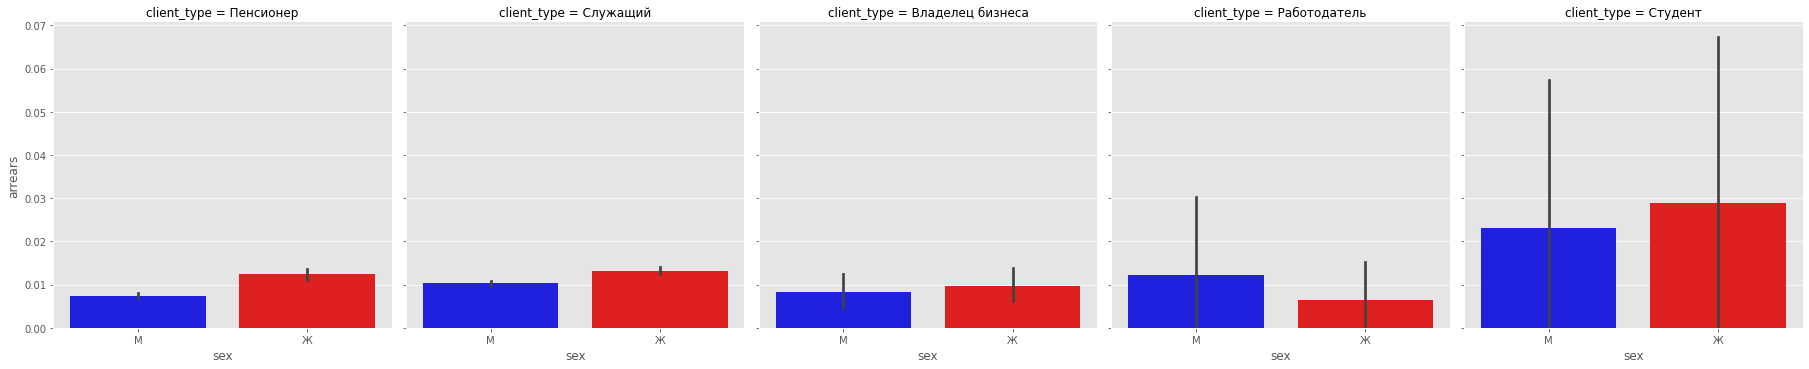

In [74]:
sns.catplot(data = df, x='sex', y='arrears', col='client_type', kind = 'bar', palette=['b', 'r'])

Графики показывают, что для различных типов занятости вероятнее всего должником будет клиент женского пола.

#### Arrears - Sex - Employer
Взаимосвязь пола и наличия работодателя от имеющейся просроченной задолженности.

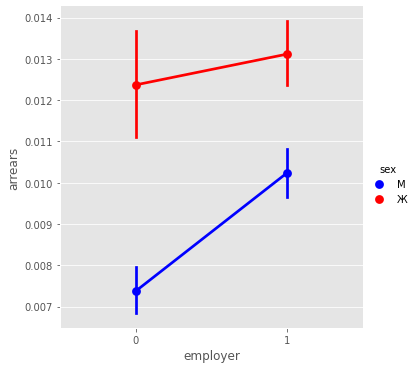

In [75]:
sns.catplot(data = df, x='employer', y='arrears', kind = 'point', hue='sex', palette=['b', 'r'])

Для мужчин вероятность просроченного долга вырастает при появлении у него работодателя. Для женщин эта вероятность возрастает незначительно.

Так как мы рассмотрели зависимости между переменными только визуально, с точки зрения статистики мы не можем говорить об истинности наших предположений.  
Вместо исследования каждой отдельной взаимосвязи, лучше построим логистическую регрессию, которая виявит статистически значимые предикторы и поможет предсказать значение `Arrears`.

### Создание индикаторных переменных
Это переменные со всего двумя значениями — ноль и единица.

In [76]:
df_regression = pd.get_dummies(data=df, prefix=['sex','family','education',
                                            'client_type','living_conditions', 'federal_district'], drop_first = True)
df_regression.head()

,employer,phones_provided,documents_provided,arrears,revenue_sum,age,sex_М,family_Женат/Замужем,family_Неофицальный брак,family_Разведен/Разведена,...,living_conditions_Живу с родителями/родственниками,living_conditions_Собственность индивидуальная,living_conditions_Собственность совместная,federal_district_central,federal_district_fareast,federal_district_northwest,federal_district_siberian,federal_district_south,federal_district_ural,federal_district_volga
0,0,4,1,0,24200.0,64,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,5,1,0,11000.0,75,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,1,5,1,0,11000.0,75,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3,1,6,1,0,30000.0,32,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,5,1,0,50000.0,70,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [77]:
df_regression.columns.values

array(['employer', 'phones_provided', 'documents_provided', 'arrears',
       'revenue_sum', 'age', 'sex_М', 'family_Женат/Замужем',
       'family_Неофицальный брак', 'family_Разведен/Разведена',
       'family_Холост/Не замужем', 'education_Другое',
       'education_Незаконченное высшее', 'education_Неполное среднее',
       'education_Несколько высших', 'education_Среднее',
       'education_Среднее специальное', 'client_type_Пенсионер',
       'client_type_Работодатель', 'client_type_Служащий',
       'client_type_Студент',
       'living_conditions_Живу с родителями/родственниками',
       'living_conditions_Собственность индивидуальная',
       'living_conditions_Собственность совместная',
       'federal_district_central', 'federal_district_fareast',
       'federal_district_northwest', 'federal_district_siberian',
       'federal_district_south', 'federal_district_ural',
       'federal_district_volga'], dtype=object)

### Логистическая регрессия
Рассчитаем модель, отберем только значимые предикторы и оценим точность

In [78]:
cols = ['employer', 'phones_provided', 'documents_provided',
       'revenue_sum', 'age', 'sex_М', 'family_Женат/Замужем',
       'family_Неофицальный брак', 'family_Разведен/Разведена',
       'family_Холост/Не замужем', 'education_Незаконченное высшее',
       'education_Неполное среднее', 'education_Несколько высших',
       'education_Среднее', 'education_Среднее специальное',
       'client_type_Пенсионер', 'client_type_Работодатель',
       'client_type_Служащий', 'client_type_Студент',
       'living_conditions_Живу с родителями/родственниками',
       'living_conditions_Собственность индивидуальная',
       'living_conditions_Собственность совместная',
       'federal_district_central', 'federal_district_fareast',
       'federal_district_northwest', 'federal_district_siberian',
       'federal_district_south', 'federal_district_ural',
       'federal_district_volga']
X = df_regression[cols]
y = df_regression['arrears']
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.056854
         Iterations 10
                                          Results: Logit
Model:                         Logit                       Pseudo R-squared:            0.018      
Dependent Variable:            arrears                     AIC:                         34235.3294 
Date:                          2023-01-10 18:17            BIC:                         34543.1191 
No. Observations:              300571                      Log-Likelihood:              -17089.    
Df Model:                      28                          LL-Null:                     -17410.    
Df Residuals:                  300542                      LLR p-value:                 1.6350e-117
Converged:                     1.0000                      Scale:                       1.0000     
No. Iterations:                10.0000                                                             
----------------------------------------

Уберем переменные с p-value > 0.05

In [79]:
cols = ['employer', 'phones_provided', 'documents_provided',
       'revenue_sum', 'age', 'sex_М', 'family_Женат/Замужем',
       'family_Неофицальный брак', 'education_Среднее',
        'education_Среднее специальное', 'client_type_Пенсионер']
X = df_regression[cols]
y = df_regression['arrears']
logit_model = sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.056928
         Iterations 9
                                Results: Logit
Model:                  Logit                Pseudo R-squared:     0.017      
Dependent Variable:     arrears              AIC:                  34243.7161 
Date:                   2023-01-10 18:17     BIC:                  34360.4639 
No. Observations:       300571               Log-Likelihood:       -17111.    
Df Model:               10                   LL-Null:              -17410.    
Df Residuals:           300560               LLR p-value:          3.6789e-122
Converged:              1.0000               Scale:                1.0000     
No. Iterations:         9.0000                                                
------------------------------------------------------------------------------
                               Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------

Подгонка модели логистической регрессии. Прогнозирование результатов тестового набора и вычисление точности.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Точность классификатора логистической регрессии для тестового набора: {:.2f}'.format(logreg.score(X_test, y_test)))

Точность классификатора логистической регрессии для тестового набора: 0.99


In [81]:
metrics.confusion_matrix(y_test, y_pred)

array([[89281,     0],
       [  891,     0]])

Результат показывает, что у нас __89 281__ верных прогнозов и __891__ ошибочных.

In [82]:
print(metrics.classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     89281
           1       1.00      0.00      0.00       891

    accuracy                           0.99     90172
   macro avg       1.00      0.50      0.50     90172
weighted avg       0.99      0.99      0.99     90172



#### Выводы
Результаты модели говорят нам о ее высокой точности - `0.99`. Также мы отобрали значимые признаки, которые положительно, либо отрицательно влияют на шансы неоплаты задолженности, что позволяет нам предсказывать конечную переменную `Arrears`, имея данные о клиенте.

В итоге значимыми переменными стали:
- Employer - Есть работодатель или нет;
- Phones Provided - Количество предоставленных телефонов;
- Documents Provided - Количество предоставленных документов;
- Revenue - Доход;
- Age - Возраст;
- Sex - Пол;
- Признак Family - категории Женат/Замужем и Неофициальный брак;
- Признак Education - категории Среднее и Среднее специальное;
- Признак Client_type - категория Пенсионер.

#### Послесловие

Далее мы могли бы применить over-sampling для увеличения частоты выборки должников, чтобы уровнять их с теми, кто платит вовремя и снова просчитать модель. Для этого есть алгоритм __SMOTE__.

На высоком уровне SMOTE:
- создаёт синтетические образцы на основе выборок минорного класса (должники) вместо создания их копий;
- случайно выбирает одного из ближайших k-соседей и использует его для создания схожих, но случайно изменённых новых сведений.